# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

**Before starting with this lab, here is a quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating).**

## Data set

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [2]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2') as source:
    speeches_201718 = pd.read_json(source)

with bz2.open('speeches-201819.json.bz2') as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [3]:
speeches_201718.head()

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD


Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [4]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [5]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

Index(['S', 'M', 'SD', 'V', 'KD', 'MP', 'C', 'L'], dtype='object')


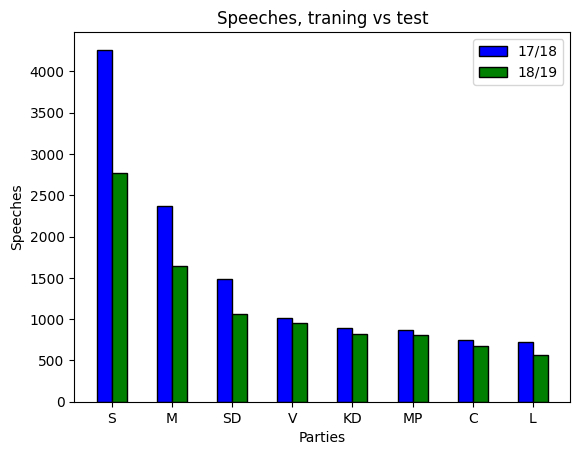

In [6]:
import matplotlib.pyplot as plt
import numpy as np
count_training = training_data['party'].value_counts()
count_test = test_data['party'].value_counts()


n=8
r = np.arange(n)
width = 0.25
print(count_test.keys())

  
plt.bar(r, count_training, color = 'b',
        width = width, edgecolor = 'black',
        label='17/18')
plt.bar(r + width, count_test, color = 'g',
        width = width, edgecolor = 'black',
        label='18/19')
plt.xticks(r + width/2,['S','M','SD','V', 'KD', 'MP', 'C', 'L'])

plt.xlabel("Parties")
plt.ylabel("Speeches")
plt.title("Speeches, traning vs test")
plt.legend()
plt.show()



*TODO: Enter your summary here*
From the plot we can derive the answer that before the general election all of the parties made more speeches than after the election.
The fact that S won both the general election 14 and 18 could be correlated that they made most speeches of all the parties.

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

In [7]:
# TODO: Write code here to train and evaluate a Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer


training_x = training_data['words']
test_x = test_data['words']

training_y = training_data['party']
test_y = test_data['party']

pipe = Pipeline(steps=[('countVec', CountVectorizer()), ('multNB', MultinomialNB())])

pipe.fit(training_x, training_y)
prediction = pipe.predict(test_x)
print(classification_report(test_y, prediction))


              precision    recall  f1-score   support

           C       0.63      0.04      0.07       671
          KD       0.70      0.02      0.03       821
           L       0.92      0.02      0.04       560
           M       0.36      0.68      0.47      1644
          MP       0.36      0.25      0.29       809
           S       0.46      0.84      0.59      2773
          SD       0.57      0.12      0.20      1060
           V       0.59      0.15      0.24       950

    accuracy                           0.43      9288
   macro avg       0.57      0.26      0.24      9288
weighted avg       0.52      0.43      0.34      9288



Would you have expected the results that you got?

Answer:
Yes, for example, if looked at S we can see a really high recall score, this would be a consequense of S maintaining the largest dataset of them all. This scews the other parties recall score and reduces them, for example look at L and KD with their 0.02 recall score. 

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [8]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(training_x,training_y)
dummy_prediction = dummy_clf.predict(training_x)

print(classification_report(training_y, dummy_prediction))


              precision    recall  f1-score   support

           C       0.07      0.07      0.07       865
          KD       0.05      0.05      0.05       743
           L       0.07      0.07      0.07       719
           M       0.19      0.19      0.19      2370
          MP       0.12      0.13      0.13      1481
           S       0.35      0.35      0.35      4261
          SD       0.07      0.08      0.07      1010
           V       0.08      0.08      0.08       894

    accuracy                           0.20     12343
   macro avg       0.13      0.13      0.13     12343
weighted avg       0.20      0.20      0.20     12343



An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [9]:
# TODO: Write code here to print the accuracy of the most frequent class baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(training_x,training_y)
dummy_prediction = dummy_clf.predict(training_x)
print(classification_report(training_y, dummy_prediction))


              precision    recall  f1-score   support

           C       0.00      0.00      0.00       865
          KD       0.00      0.00      0.00       743
           L       0.00      0.00      0.00       719
           M       0.00      0.00      0.00      2370
          MP       0.00      0.00      0.00      1481
           S       0.35      1.00      0.51      4261
          SD       0.00      0.00      0.00      1010
           V       0.00      0.00      0.00       894

    accuracy                           0.35     12343
   macro avg       0.04      0.12      0.06     12343
weighted avg       0.12      0.35      0.18     12343



/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Summarise your results in a short text.

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [10]:
# TODO: Write code here to implement undersampling
def undersample(party):
    #Get maximum sample size which is 719 (5752/8 = 719)
    sample_size = sum(training_data.party == "L")
    speeches_party = training_data[training_data.party == party].index
    #retreive 719 random samples (speeches) from the party 
    random_indices = np.random.choice(speeches_party, sample_size, replace=False)
    return training_data.loc[random_indices]
S = undersample("S")
M = undersample("M")
MP = undersample("MP")
C = undersample("C")
SD = undersample("SD")
KD = undersample("KD")
V = undersample("V")
L = undersample("L")

print("Total speeches")
print(len(S)+ len(M) + len(MP) + len(C) + len(SD) + len(KD) +len(V) + len(L))


Total speeches
5752


In [11]:
frames = [S, M, MP, C, SD, KD, V, L]
#add all undersampled parties to a pandas dataframe
undersample_traning = pd.concat(frames)


undersample_traning_x = undersample_traning['words']
undersample_traning_y = undersample_traning['party']

undersample_pipe = Pipeline([('countVec', CountVectorizer()), ('multNB', MultinomialNB())])

undersample_pipe.fit(undersample_traning_x, undersample_traning_y)
undersample_prediction = undersample_pipe.predict(test_x)
print(classification_report(test_y, undersample_prediction))

              precision    recall  f1-score   support

           C       0.30      0.42      0.35       671
          KD       0.30      0.40      0.34       821
           L       0.26      0.43      0.32       560
           M       0.41      0.48      0.44      1644
          MP       0.35      0.39      0.37       809
           S       0.79      0.32      0.45      2773
          SD       0.44      0.42      0.43      1060
           V       0.39      0.57      0.46       950

    accuracy                           0.41      9288
   macro avg       0.40      0.43      0.40      9288
weighted avg       0.49      0.41      0.42      9288



*TODO: Enter the summary of your results here*
By undersample, we can see that the accuracy decreased by 5% but the recall is much more even now when it is equally distributed.
Something to comment on is that the bigger parties (with many speeches) went from a low precision high recall to a higher precision and lower recall, especially S. A reason behind this could be that when evenly distributed, there are less false positives and more false negatives within these classes. 

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). If you would rather see a visual representation, you can also use [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


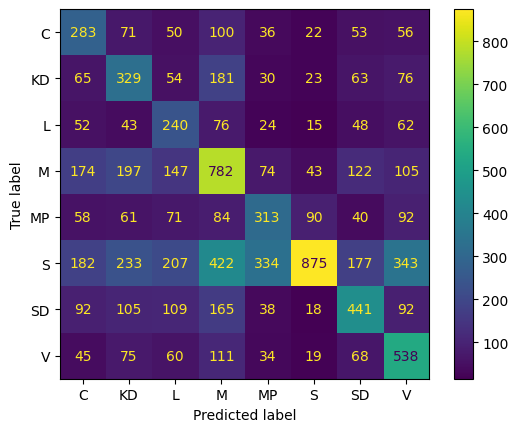

[[283  71  50 100  36  22  53  56]
 [ 65 329  54 181  30  23  63  76]
 [ 52  43 240  76  24  15  48  62]
 [174 197 147 782  74  43 122 105]
 [ 58  61  71  84 313  90  40  92]
 [182 233 207 422 334 875 177 343]
 [ 92 105 109 165  38  18 441  92]
 [ 45  75  60 111  34  19  68 538]]


In [12]:
# TODO: Write code here to solve Problem 5
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(undersample_pipe, test_x, test_y)
plt.show()

confusion_matrix = confusion_matrix(test_y,undersample_prediction )
print(confusion_matrix)

Take a minute to reflect on whether your results make sense.

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words (binary) model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [13]:
# TODO: Write code here to implement the grid search
from sklearn.model_selection import GridSearchCV
parameters = {
    'countVec__binary':[True, False], 
    'countVec__ngram_range':[(1,1), (1,2)], 
    'multNB__alpha': (1, 0.1)
    }

clf  = GridSearchCV(undersample_pipe, parameters, cv=5)



In [14]:
clf.fit(undersample_traning_x, undersample_traning_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countVec', CountVectorizer()),
                                       ('multNB', MultinomialNB())]),
             param_grid={'countVec__binary': [True, False],
                         'countVec__ngram_range': [(1, 1), (1, 2)],
                         'multNB__alpha': (1, 0.1)})

In [15]:
print(clf.best_score_)
print(clf.best_params_)

0.6279598081063724
{'countVec__binary': True, 'countVec__ngram_range': (1, 2), 'multNB__alpha': 0.1}


In [16]:
grid_undersample_pipe = Pipeline(steps=[('countVec', CountVectorizer(binary=False, ngram_range=(1,2))), ('multNB', MultinomialNB(alpha=0.1))])

grid_undersample_pipe.fit(undersample_traning_x, undersample_traning_y)
grid_undersample_prediction = grid_undersample_pipe.predict(test_x)
print(classification_report(test_y, grid_undersample_prediction))

              precision    recall  f1-score   support

           C       0.32      0.44      0.37       671
          KD       0.33      0.40      0.36       821
           L       0.27      0.44      0.33       560
           M       0.47      0.47      0.47      1644
          MP       0.33      0.43      0.38       809
           S       0.76      0.44      0.56      2773
          SD       0.49      0.45      0.47      1060
           V       0.46      0.58      0.51       950

    accuracy                           0.46      9288
   macro avg       0.43      0.46      0.43      9288
weighted avg       0.51      0.46      0.47      9288



## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model.

In [17]:
# TODO: Write code here to search for a better model and print the results
#Reading on the list of different naive bayes models 
#from https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes
# We choose complementNB because its trait for handeling imbalanced sets, which we have.
#We also wanted to try linearSVC and see what difference it made
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB

improved_pipe_compNB = Pipeline(steps=[('countVec', CountVectorizer()), ('compNB', ComplementNB())])
improved_pipe_SVC = Pipeline(steps=[('countVec', CountVectorizer()), ('linSVC', LinearSVC())])

improved_pipe_compNB.fit(undersample_traning_x, undersample_traning_y)
prediction_compNB = improved_pipe_compNB.predict(test_x)
print('------ ComplementNB -------')
print(classification_report(test_y, prediction_compNB))

improved_pipe_SVC.fit(undersample_traning_x, undersample_traning_y)
prediction_SVC = improved_pipe_SVC.predict(test_x)
print('------ SVC -------')
print(classification_report(test_y, prediction_SVC))




------ ComplementNB -------
              precision    recall  f1-score   support

           C       0.33      0.43      0.37       671
          KD       0.34      0.41      0.37       821
           L       0.29      0.46      0.35       560
           M       0.49      0.35      0.41      1644
          MP       0.29      0.42      0.34       809
           S       0.71      0.38      0.49      2773
          SD       0.40      0.51      0.44      1060
           V       0.38      0.55      0.45       950

    accuracy                           0.42      9288
   macro avg       0.40      0.44      0.41      9288
weighted avg       0.48      0.42      0.43      9288

------ SVC -------
              precision    recall  f1-score   support

           C       0.29      0.41      0.34       671
          KD       0.30      0.27      0.29       821
           L       0.23      0.39      0.29       560
           M       0.48      0.36      0.41      1644
          MP       0.24      0.

Deriving the report, they are very much alike based on accuracy, but complementNB was a little bit better. Lets try tuning the hyperparameters of both.

In [18]:
parameters = {
    'countVec__binary':[True, False], 
    'countVec__ngram_range':[(1,1), (1,2)], 
    'compNB__alpha': (1,0.8,0.5,0.2,0.1)
    }

clf  = GridSearchCV(improved_pipe_compNB, parameters, cv=5)
clf.fit(training_x, training_y)
print(clf.best_params_)

{'compNB__alpha': 0.2, 'countVec__binary': False, 'countVec__ngram_range': (1, 2)}


In [20]:
parameters = {
    'countVec__binary':[True, False], 
    'countVec__ngram_range':[(1,1), (1,2)], 
    'linSVC__penalty': ('l1', 'l2'),
    'linSVC__loss': ('hinge', 'squared_hinge')
    }

clf  = GridSearchCV(improved_pipe_SVC, parameters, cv=5)
clf.fit(training_x, training_y)
print(clf.best_params_)

/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/glockengold/dev/tdde16/tdde16_venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home

{'countVec__binary': True, 'countVec__ngram_range': (1, 2), 'linSVC__loss': 'squared_hinge', 'linSVC__penalty': 'l2'}


In [22]:
grid_improved_pipe_compNB = Pipeline(steps=[('countVec', CountVectorizer(binary=False, ngram_range=(1,2))), ('compNB', ComplementNB(alpha=0.2))])
grid_improved_pipe_compNB.fit(training_x, training_y)
grid_prediction_compNB = grid_improved_pipe_compNB.predict(test_x)
print('------ ComplementNB -------')
print(classification_report(test_y, grid_prediction_compNB))

------ ComplementNB -------
              precision    recall  f1-score   support

           C       0.57      0.24      0.34       671
          KD       0.61      0.25      0.36       821
           L       0.56      0.24      0.34       560
           M       0.44      0.64      0.52      1644
          MP       0.38      0.33      0.35       809
           S       0.55      0.80      0.65      2773
          SD       0.57      0.37      0.45      1060
           V       0.56      0.37      0.45       950

    accuracy                           0.51      9288
   macro avg       0.53      0.41      0.43      9288
weighted avg       0.53      0.51      0.49      9288



In [23]:
grid_improved_pipe_SVC = Pipeline(steps=[('countVec', CountVectorizer(binary=True, ngram_range=(1,2))), ('linSVC', LinearSVC(penalty='l2', loss='squared_hinge'))])
grid_improved_pipe_SVC.fit(training_x, training_y)
grid_prediction_SVC = grid_improved_pipe_SVC.predict(test_x)
print('------ SVC -------')
print(classification_report(test_y, grid_prediction_SVC))

------ SVC -------
              precision    recall  f1-score   support

           C       0.48      0.34      0.40       671
          KD       0.56      0.21      0.31       821
           L       0.39      0.26      0.32       560
           M       0.49      0.52      0.50      1644
          MP       0.30      0.37      0.33       809
           S       0.54      0.78      0.64      2773
          SD       0.51      0.40      0.45      1060
           V       0.64      0.37      0.47       950

    accuracy                           0.50      9288
   macro avg       0.49      0.41      0.43      9288
weighted avg       0.51      0.50      0.48      9288



Using the tuned hyperparameters, we can see an improvement of around 10 percentage points for both models, though the Complement Naive Bayes is still slightly ahead of the Support Vector Machine by 1 percentage point. At this point we can conclude that both methods give decent models, though the Complement Naive Bayes gives a heigher weighted average accuracy, resulting in the heigher average F1-score.

## Reflection questions

The following reflection questions will help you prepare for the diagnostic test. Answer each of them in the form of a short text and put your answers in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 2.1:** Summarise the results of your experiments for Problem&nbsp;2. Are your results ‘good’ or ‘bad’? How do you determine that?

**RQ 2.2:** Summarise the results of your experiments for Problem&nbsp;4. Would you think that your results are typical even for other classification tasks? How would *oversampling* have looked like for this task? When would you use undersampling, when oversampling?

**RQ 2.3:** Which model performed best in your experiments for Problem&nbsp;6? Why is it important to do a hyperparameter search before drawing conclusions about the performance of a model? Why is it often not done, anyway? Why should you never tune hyperparameters on the test set?


**2.1** We are basing how good multinominal naive bayes is compared to the dummy class. The multiNB has an accuarcy around 44% which is better than the dummy test on 19% and 35% (though the most frequent dummy classifer has divison by zero) which makes it "good" in that it is better than random sampling or which class appears most often. However you can not only look at the accuarcy, as the undersampled dataset has lower accuarcy but better recall. We would say that the result is decent, in that it is better than random choice, but could certainly use some improvement. 

**2.2** I would argue that the result is typical for other classification tasks. Oversampling in other cases could be getting data from a form evaluating a process at school. If we were to say that there were 90% men och 10% women who took the survey it analysed, it could be more scewed to what the men found interesting because of the fact that there would be more documents of one category compared to another. 

One would use oversampling when information is sparse to increase the data.
One would use undersampling when there are a lot of information in two or more data set and you want to equalize all the datasets.


**2.3** The Complement Naive Bayes model performed best in P6. It is important to tune the hyperparameters correctly to get better value and performance of a dataset. Using only the base parameters of the model will not always output the best performance. We would argue that the performance increase is often so minimal that data scientists do not bother with the increase. In our case, tuning the hyperparameters resulted in an increase of 10 percentage points, which is not insubstantial, but such an increase is not necessarily the norm.
It is important to not tune the model on your test data, because it would skew all results, and cause the model to overfit on a specific dataset. Using untainted test data ensures that the model can generalize properly to new information.


**Congratulations on finishing L2! 👍**